# Import

In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm
import math
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Data Load

In [2]:
train = pd.read_csv('../open/train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('../open/test.csv').drop(columns=['SAMPLE_ID'])

# Data Pre-processing

In [3]:
# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

In [4]:
# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

In [5]:
# Categorical 컬럼 인코딩
categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']


for feature in tqdm(categorical_features, desc="Encoding features"):
    encoder = LabelEncoder()
    train[feature] = encoder.fit_transform(train[feature])
    for label in np.unique(test[feature]):
        if label not in encoder.classes_:
            encoder.classes_ = np.append(encoder.classes_, label)
    test[feature] = encoder.transform(test[feature])

Encoding features: 100%|█████████████████████████████████████████████████████████████████| 6/6 [00:11<00:00,  1.95s/it]


In [6]:
# 결측치 처리
train.fillna(train.mean(), inplace=True)
test.fillna(train.mean(), inplace=True)

C:\Users\pc\AppData\Local\Temp\ipykernel_36756\3687844134.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  train.fillna(train.mean(), inplace=True)
C:\Users\pc\AppData\Local\Temp\ipykernel_36756\3687844134.py:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  test.fillna(train.mean(), inplace=True)


# Data Generation

In [7]:
# OIL
train['OIL'] = (train['WTI']+train['DUBAI']+train['BRENT'])/3
test['OIL'] = (test['WTI']+test['DUBAI']+test['BRENT'])/3

# OIL 평균과 합산 중에 평균이 더 높은 점수 평균 사용
# 바꾸고 싶으면 아래 코드 사용

#train['OIL'] = (train['WTI']+train['DUBAI']+train['BRENT'])
#test['OIL'] = (test['WTI']+test['DUBAI']+test['BRENT'])

In [8]:
# ATA_LT SIN-COS
train['COS_ATA_LT'] = np.cos(2*np.pi*(train.ATA_LT/24))
train['SIN_ATA_LT'] = np.sin(2*np.pi*(train.ATA_LT/24))

test['COS_ATA_LT'] = np.cos(2*np.pi*(test.ATA_LT/24))
test['SIN_ATA_LT'] = np.sin(2*np.pi*(test.ATA_LT/24))

In [9]:
# USD
# 1. Load the USD data
usd_data = pd.read_csv("../open/USD.csv")

# 2. Convert the '날짜' column in USD data to datetime format
usd_data['날짜'] = pd.to_datetime(usd_data['날짜'], format='%Y-%m-%d').dt.date

# Convert the 'ATA' column in train and test data to only the date format
train['ATA_date'] = pd.to_datetime(train['ATA']).dt.date
test['ATA_date'] = pd.to_datetime(test['ATA']).dt.date

# 3. Merge the USD data with train and test data on the date columns
train_merged = pd.merge(train, usd_data, left_on='ATA_date', right_on='날짜', how='left')
test_merged = pd.merge(test, usd_data, left_on='ATA_date', right_on='날짜', how='left')

# Drop the '날짜' and 'ATA_date' columns from merged datasets as they are redundant
train_merged.drop(['날짜', 'ATA_date'], axis=1, inplace=True)
test_merged.drop(['날짜', 'ATA_date'], axis=1, inplace=True)
train_merged.drop(['거래량', '변동 %'],axis=1,inplace=True)
test_merged.drop(['거래량', '변동 %'],axis=1,inplace=True)
train_merged.drop(['시가', '고가', '저가'],axis=1,inplace=True)
test_merged.drop(['시가', '고가', '저가'],axis=1,inplace=True)
train_merged['종가'] = train_merged['종가'].str.replace(',', '').astype(float)
test_merged['종가'] = test_merged['종가'].str.replace(',', '').astype(float)
train = train_merged.copy()
test = test_merged.copy()

In [10]:
# round_hour
train['rounded_hour'] = (train['ATA'].dt.hour + (train['ATA'].dt.minute // 30)).apply(lambda x: 0 if x == 24 else x)
test['rounded_hour'] = (test['ATA'].dt.hour + (test['ATA'].dt.minute // 30)).apply(lambda x: 0 if x == 24 else x)

In [11]:
# Date SIN-COS
# sin, cos 변환 함수 정의
def encode_cyclic_feature(data, column, max_val):
    data[column + '_sin'] = np.sin(2 * np.pi * data[column] / max_val)
    data[column + '_cos'] = np.cos(2 * np.pi * data[column] / max_val)
    return data

# 각 피처에 대해 sin, cos 변환 수행
train = encode_cyclic_feature(train, 'month', 12)
train = encode_cyclic_feature(train, 'day', 31)
train = encode_cyclic_feature(train, 'weekday', 7)
train = encode_cyclic_feature(train, 'rounded_hour', 24)
test = encode_cyclic_feature(test, 'month', 12)
test = encode_cyclic_feature(test, 'day', 31)
test = encode_cyclic_feature(test, 'weekday', 7)
test = encode_cyclic_feature(test, 'rounded_hour', 24)

train.drop(['ATA'],axis=1,inplace=True)
test.drop(['ATA'],axis=1,inplace=True)

In [12]:
#OIL PCA
# 1. Select the features for PCA
features = ['WTI', 'BRENT', 'DUBAI']
train_subset = train[features]
test_subset = test[features]

# 3. Apply PCA and get 2 principal components
pca = PCA(n_components=1)
train_pca = pca.fit_transform(train_subset)
test_pca = pca.transform(test_subset)

# 4. Add the principal components to the train and test data
train['PCA1'] = train_pca[:, 0]
test['PCA1'] = test_pca[:, 0]

In [13]:
# OIL 종가 PCA
# 1. Select the features for PCA
features = ['WTI', '종가']
train_subset = train[features]
test_subset = test[features]

# 3. Apply PCA and get 2 principal components
pca = PCA(n_components=1)
train_pca = pca.fit_transform(train_subset)
test_pca = pca.transform(test_subset)

# 4. Add the principal components to the train and test data
train['PCA2'] = train_pca[:, 0]
test['PCA2'] = test_pca[:, 0]

In [14]:
# Polynomial
train['DUBAI_squared'] = train['DUBAI'] ** 2
train['BRENT_squared'] = train['BRENT'] ** 2
train['WTI_squared'] = train['WTI'] ** 2

test['DUBAI_squared'] = test['DUBAI'] ** 2
test['BRENT_squared'] = test['BRENT'] ** 2
test['WTI_squared'] = test['WTI'] ** 2

In [15]:
# Ratio
# 2. Ratios
train['DUBAI_WTI_ratio'] = train['DUBAI'] / train['WTI']
train['BRENT_WTI_ratio'] = train['BRENT'] / train['WTI']

# 2. Ratios
test['DUBAI_WTI_ratio'] = test['DUBAI'] / test['WTI']
test['BRENT_WTI_ratio'] = test['BRENT'] / test['WTI']

In [16]:
# Ratios with oil prices
train['BDI_ADJ_DUBAI_ratio'] = train['BDI_ADJ'] / train['DUBAI']
train['BDI_ADJ_BRENT_ratio'] = train['BDI_ADJ'] / train['BRENT']
train['BDI_ADJ_WTI_ratio'] = train['BDI_ADJ'] / train['WTI']

test['BDI_ADJ_DUBAI_ratio'] = test['BDI_ADJ'] / test['DUBAI']
test['BDI_ADJ_BRENT_ratio'] = test['BDI_ADJ'] / test['BRENT']
test['BDI_ADJ_WTI_ratio'] = test['BDI_ADJ'] / test['WTI']

C:\Users\pc\anaconda3\envs\HD\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\pc\anaconda3\envs\HD\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\pc\anaconda3\envs\HD\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\pc\anaconda3\envs\HD\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1

KElbowVisualizer(ax=<Axes: >, estimator=KMeans(n_clusters=9), k=(1, 10))

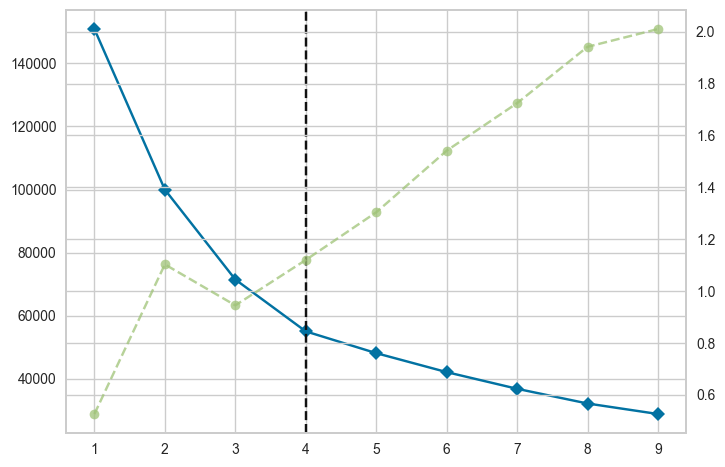

In [17]:
# Ship info category

ship_info = ['SHIP_TYPE_CATEGORY','BREADTH','BUILT','DEADWEIGHT','DEPTH','DRAUGHT','GT','LENGTH','FLAG']

train_data = train[ship_info]
test_data = test[ship_info]

scaler = MinMaxScaler()
train_data_scale = scaler.fit_transform(train_data)
test_data_scale = scaler.transform(test_data)

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(train_data_scale)

In [18]:
k = 4

# 그룹 수, random_state 설정
model = KMeans(n_clusters = k, random_state = 10)

# 정규화된 데이터에 학습
model.fit(train_data_scale)

# 클러스터링 결과 각 데이터가 몇 번째 그룹에 속하는지 저장
train['ship_cluster'] = model.fit_predict(train_data_scale)
test['ship_cluster'] = model.predict(test_data_scale)

C:\Users\pc\anaconda3\envs\HD\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\pc\anaconda3\envs\HD\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


# Info

In [19]:
trian_target = train['CI_HOUR']
train.drop(['CI_HOUR'],axis=1,inplace=True)
train['CI_HOUR'] = trian_target

In [20]:
print(train.shape)
print(test.shape)

(367441, 55)
(244989, 54)


In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 367441 entries, 0 to 367440
Data columns (total 55 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ARI_CO               367441 non-null  int32  
 1   ARI_PO               367441 non-null  int32  
 2   SHIP_TYPE_CATEGORY   367441 non-null  int32  
 3   DIST                 367441 non-null  float64
 4   ID                   367441 non-null  int32  
 5   BREADTH              367441 non-null  float64
 6   BUILT                367441 non-null  int64  
 7   DEADWEIGHT           367441 non-null  int64  
 8   DEPTH                367441 non-null  float64
 9   DRAUGHT              367441 non-null  float64
 10  GT                   367441 non-null  int64  
 11  LENGTH               367441 non-null  float64
 12  SHIPMANAGER          367441 non-null  int32  
 13  FLAG                 367441 non-null  int32  
 14  U_WIND               367441 non-null  float64
 15  V_WIND           

In [22]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 244989 entries, 0 to 244988
Data columns (total 54 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ARI_CO               244989 non-null  int32  
 1   ARI_PO               244989 non-null  int32  
 2   SHIP_TYPE_CATEGORY   244989 non-null  int32  
 3   DIST                 244989 non-null  float64
 4   ID                   244989 non-null  int32  
 5   BREADTH              244989 non-null  float64
 6   BUILT                244989 non-null  int64  
 7   DEADWEIGHT           244989 non-null  int64  
 8   DEPTH                244989 non-null  float64
 9   DRAUGHT              244989 non-null  float64
 10  GT                   244989 non-null  int64  
 11  LENGTH               244989 non-null  float64
 12  SHIPMANAGER          244989 non-null  int32  
 13  FLAG                 244989 non-null  int32  
 14  U_WIND               244989 non-null  float64
 15  V_WIND           

In [23]:
train.isna().sum()

ARI_CO                 0
ARI_PO                 0
SHIP_TYPE_CATEGORY     0
DIST                   0
ID                     0
BREADTH                0
BUILT                  0
DEADWEIGHT             0
DEPTH                  0
DRAUGHT                0
GT                     0
LENGTH                 0
SHIPMANAGER            0
FLAG                   0
U_WIND                 0
V_WIND                 0
AIR_TEMPERATURE        0
BN                     0
ATA_LT                 0
DUBAI                  0
BRENT                  0
WTI                    0
BDI_ADJ                0
PORT_SIZE              0
year                   0
month                  0
day                    0
hour                   0
minute                 0
weekday                0
OIL                    0
COS_ATA_LT             0
SIN_ATA_LT             0
종가                     0
rounded_hour           0
month_sin              0
month_cos              0
day_sin                0
day_cos                0
weekday_sin            0


In [24]:
test.isna().sum()

ARI_CO                 0
ARI_PO                 0
SHIP_TYPE_CATEGORY     0
DIST                   0
ID                     0
BREADTH                0
BUILT                  0
DEADWEIGHT             0
DEPTH                  0
DRAUGHT                0
GT                     0
LENGTH                 0
SHIPMANAGER            0
FLAG                   0
U_WIND                 0
V_WIND                 0
AIR_TEMPERATURE        0
BN                     0
ATA_LT                 0
DUBAI                  0
BRENT                  0
WTI                    0
BDI_ADJ                0
PORT_SIZE              0
year                   0
month                  0
day                    0
hour                   0
minute                 0
weekday                0
OIL                    0
COS_ATA_LT             0
SIN_ATA_LT             0
종가                     0
rounded_hour           0
month_sin              0
month_cos              0
day_sin                0
day_cos                0
weekday_sin            0


In [25]:
display(train.head())
display(test.head())

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,...,DUBAI_squared,BRENT_squared,WTI_squared,DUBAI_WTI_ratio,BRENT_WTI_ratio,BDI_ADJ_DUBAI_ratio,BDI_ADJ_BRENT_ratio,BDI_ADJ_WTI_ratio,ship_cluster,CI_HOUR
0,4,13,0,30.736578,24337,30.0,28,73100,20.0,10.0,...,1764.8401,1862.7856,1677.7216,1.025635,1.053711,33.507935,32.615114,34.366903,1,3.048333
1,4,14,2,63.220425,19552,30.0,15,37900,20.0,10.0,...,4560.3009,4166.7025,3521.2356,1.138018,1.087799,30.935092,32.363234,35.204698,3,17.138611
2,4,45,2,90.427421,20449,50.0,7,115000,20.0,10.0,...,4264.0900,4407.6321,3242.1636,1.146821,1.165964,9.237260,9.085601,10.593485,3,98.827500
3,8,75,1,0.000000,1689,10.0,33,1490,10.0,0.0,...,1850.7204,1861.9225,1690.0321,1.046461,1.049623,27.193246,27.111320,28.456664,2,0.000000
4,16,46,2,8.813725,2989,30.0,10,27600,10.0,10.0,...,8181.2025,8770.3225,7763.3721,1.026558,1.062876,12.249253,11.830698,12.574565,2,96.030556


,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,...,PCA2,DUBAI_squared,BRENT_squared,WTI_squared,DUBAI_WTI_ratio,BRENT_WTI_ratio,BDI_ADJ_DUBAI_ratio,BDI_ADJ_BRENT_ratio,BDI_ADJ_WTI_ratio,ship_cluster
0,8,25,3,9.508139,16892,20.0,9,5510,10.0,10.0,...,172.427931,9580.4944,9310.3201,8019.2025,1.093021,1.077499,7.835897,7.948778,8.564798,2
1,17,21,2,24.186684,5748,40.0,14,109000,20.0,10.0,...,58.481090,9631.4596,10949.5296,10120.3600,0.975547,1.040159,16.863733,15.816196,16.451360,3
2,19,13,1,0.000000,15243,20.0,14,13700,10.0,10.0,...,67.938590,7005.6900,7221.6004,6317.0704,1.053095,1.069200,8.155258,8.032421,8.588263,2
3,8,25,0,0.000000,1313,10.0,18,2840,10.0,10.0,...,-62.425397,1509.3225,1747.2400,1561.0401,0.983295,1.057960,16.200208,15.056892,15.929590,1
4,17,21,2,19.834186,8869,30.0,23,30700,20.0,10.0,...,62.964326,7035.8544,7418.3769,6420.8169,1.046799,1.074878,6.713185,6.537814,7.027355,3


# CSV

In [26]:
train.to_csv('../open/train_merge.csv',index=False)
test.to_csv('../open/test_merge.csv',index=False)